<a href="https://colab.research.google.com/github/lucinnnal/DNN_Final_Project/blob/main/Datasets_with_additional_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torchvision import transforms
from transformers import AutoImageProcessor, SegformerModel
from transformers import SegformerForSemanticSegmentation

In [2]:
image_processor = AutoImageProcessor.from_pretrained("nvidia/mit-b0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import AutoImageProcessor

class CustomDataset(Dataset):
    def __init__(self, data_dir, json_dir, image_processor, size=None):
        """
        :param data_dir: 이미지 파일이 저장된 디렉터리
        :param json_dir: JSON 레이블 파일이 저장된 디렉터리 (각 이미지에 대응하는 JSON 파일)
        :param image_processor: AutoImageProcessor 인스턴스 (예: AutoImageProcessor.from_pretrained("nvidia/mit-b0"))
        :param size: 이미지 리사이즈 크기 (선택 사항)
        """
        self.data_dir = data_dir
        self.json_dir = json_dir
        self.image_processor = image_processor
        self.size = size

        # 이미지 파일 목록 (data_dir에 있는 이미지 파일들)
        self.image_files = [f for f in os.listdir(self.data_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # 손상 유형에 대한 맵핑 (예: "Crushed" -> 1, "Scratched" -> 2, 등)
        self.damage_to_class = {
            "Crushed": 1,
            "Scratched": 2,
            "Separated": 3,
            "Breakage": 4,
        }

    def __getitem__(self, index: int):
        # 이미지 파일 경로
        image_file = self.image_files[index]
        image_path = os.path.join(self.data_dir, image_file)

        # JSON 파일 경로 (이미지 파일 이름에 대응하는 JSON 파일)
        json_file = os.path.splitext(image_file)[0] + ".json"
        json_path = os.path.join(self.json_dir, json_file)

        # JSON 레이블 파일 로드
        with open(json_path, 'r') as f:
            annotations = json.load(f)

        # 이미지 로드
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 이미지 RGB로 변환

        # 마스크 생성 (배경을 0으로 설정)
        height, width, _ = image.shape
        masks = np.zeros((height, width), dtype=np.int32)  # 각 픽셀은 손상 유형의 인덱스를 가짐 (0: 배경)

        # JSON 주석에 포함된 segmentation 정보를 바탕으로 마스크 생성
        for ann in annotations['annotations']:
            segmentation = ann['segmentation']
            damage_type = ann['damage']

            # damage_type을 숫자로 변환
            class_id = self.damage_to_class.get(damage_type, 0)  # 해당 손상 유형에 맞는 클래스 번호 (기본값: 0)

            for seg in segmentation:
                # 다각형 마스크로 변환
                polygon = np.array(seg[0], dtype=np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(masks, [polygon], class_id)  # 손상 유형에 맞는 클래스 번호로 채움

        # 이미지 리사이즈가 필요한 경우
        if self.size:
            image = cv2.resize(image, (self.size, self.size))
            masks = cv2.resize(masks, (self.size, self.size), interpolation=cv2.INTER_NEAREST)

        # 이미지 프로세서로 전처리 (이미지 전처리)
        inputs = self.image_processor(images=image, return_tensors="pt")

        # image_processor는 기본적으로 이미지만 처리하므로, 마스크에 대한 추가 처리가 필요합니다.
        # 마스크는 크기 조정 후 그대로 반환
        mask_tensor = torch.tensor(masks).unsqueeze(0)  # (1, H, W)

        return inputs.pixel_values.squeeze(0), mask_tensor.long(), image_file

    def __len__(self):
        return len(self.image_files)


In [5]:
sample_file_path = '/content/drive/MyDrive/Segformer_Final_Project/Data/train/image'
json_file_path = '/content/drive/MyDrive/Segformer_Final_Project/Data/train/label'
dataset = CustomDataset(data_dir=sample_file_path, json_dir=json_file_path, image_processor=image_processor, size = 512)

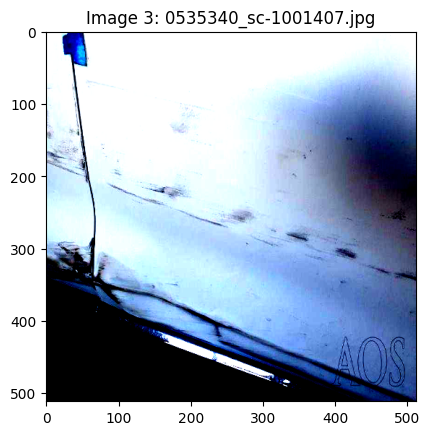

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

image = dataset[3][0].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# 이미지 시각화
plt.imshow(image)
plt.title(f"Image {3}: {dataset.image_files[3]}")
plt.show()

In [10]:
from torch.utils.data import DataLoader

# 배치 크기 설정
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 배치 처리 예시
for images, masks, filenames in dataloader:
    # images, masks, filenames는 각각 배치로 들어옴
    print(images.shape, masks.shape, filenames)
    break

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512]) ('0562077_as-3384250.jpg', '0507753_sc-225693.jpg', '0546284_as-0030637.jpg', '0549767_as-0018367.jpg', '0518763_sc-1030266.jpg', '0552820_as-0087893.jpg', '0506263_sc-222093.jpg', '0540492_sc-137971.jpg')


In [7]:
image_processor = AutoImageProcessor.from_pretrained("nvidia/mit-b0")
model = SegformerModel.from_pretrained("nvidia/mit-b0", num_labels=5) # 배경 하나, 그리고 분류하려는 손사의 종류 4개 -> 5개

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

segmap shape 확인하기

In [ ]:
'''input_example = dataset[3][0].unsqueeze(0)
output = model(input_example)
last_hidden_state = output.last_hidden_state

upsampled = nn.functional.interpolate(
    last_hidden_state,
    size= (512, 512), # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled.argmax(dim=1)[0]
print(f"predicted segmentation map size: {pred_seg.size()}")'''

predicted segmentation map size: torch.Size([512, 512])


In [8]:
# Criterion/Optimizer/ ect -> Hyperparameters
# batch_size is 64
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-06)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

SegformerModel(
  (encoder): SegformerEncoder(
    (patch_embeddings): ModuleList(
      (0): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (1): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (2): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
      )
      (3): SegformerOverlapPatchEmbeddings(
        (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (block): ModuleList(
      (0): ModuleList(
        (0): SegformerL

In [ ]:
for epoch in epochs:

  model.train()
  print(f"Epoch : {epoch+1}")

  train_losses = []

  for step, (images, masks, _) in enumerate(dataloader):

    images = torch.tensor(images).float().to(device)
    masks = torch.tensor(masks).long().to(device)

    outputs = model(images)

    loss = criterion(outputs, masks)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
      print(f"{step} : {loss.item()}")
      train_losses.append(loss.item())

In [11]:
import time
from tqdm import tqdm

for epoch in range(epochs):
    model.train()
    print(f"Epoch : {epoch+1}")

    # Epoch 시작 시간 기록
    epoch_start_time = time.time()

    train_losses = []

    # tqdm으로 진행률 표시
    for step, (images, masks, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}", ncols=100)):

        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)

        last_hidden_state = outputs.last_hidden_state

        upsampled = nn.functional.interpolate(
            last_hidden_state,
            size=(images.size(2), images.size(3)), # (height, width)
            mode='bilinear',
            align_corners=False
            )

        loss = criterion(upsampled, masks.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"{step} : {loss.item()}, elapsed time : {time}")
            train_losses.append(loss.item())

    # Epoch 종료 시간 기록
    epoch_end_time = time.time()

    # Epoch 소요 시간 계산
    epoch_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds.")

Epoch : 1


Epoch 1:   0%|                                                              | 0/504 [00:07<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.37 GiB is free. Process 2998 has 13.38 GiB memory in use. Of the allocated memory 13.24 GiB is allocated by PyTorch, and 15.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [12]:
torch.cuda.memory_allocated()

14210812928